# Taste or Waste?

**Name(s)**: Christopher Shang and In Lorthongpanich

**Website Link**: ([Link](https://invividl.github.io/recipes-ratings-analysis/#in-lorthongpanich-christopher-shang))

In [66]:
import pandas as pd
import numpy as np

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import (
    PolynomialFeatures, OneHotEncoder, FunctionTransformer, StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)

## Step 1: Introduction

In [67]:
interactions = pd.read_csv('RAW_interactions.csv')
interactions.head()

user_id  recipe_id        date  rating  \
0     1293707      40893  2011-12-21       5   
1      126440      85009  2010-02-27       5   
2       57222      85009  2011-10-01       5   
3      124416     120345  2011-08-06       0   
4  2000192946     120345  2015-05-10       2   

                                              review  
0  So simple, so delicious! Great for chilly fall...  
1  I made the Mexican topping and took it to bunk...  
2  Made the cheddar bacon topping, adding a sprin...  
3  Just an observation, so I will not rate.  I fo...  
4  This recipe was OVERLY too sweet.  I would sta...

In [68]:
recipes = pd.read_csv('RAW_recipes.csv')
recipes.head()

name      id  minutes  contributor_id  \
0  1 brownies in the world    best ever  333281       40          985201   
1    1 in canada chocolate chip cookies  453467       45         1848091   
2                412 broccoli casserole  306168       40           50969   
3                millionaire pound cake  286009      120          461724   
4                         2000 meatloaf  475785       90         2202916   

    submitted                                               tags  \
0  2008-10-27  ['60-minutes-or-less', 'time-to-make', 'course...   
1  2011-04-11  ['60-minutes-or-less', 'time-to-make', 'cuisin...   
2  2008-05-30  ['60-minutes-or-less', 'time-to-make', 'course...   
3  2008-02-12  ['time-to-make', 'course', 'cuisine', 'prepara...   
4  2012-03-06  ['time-to-make', 'course', 'main-ingredient', ...   

                                       nutrition  n_steps  \
0       [138.4, 10.0, 50.0, 3.0, 3.0, 19.0, 6.0]       10   
1   [595.1, 46.0, 211.0, 22.0, 13.0, 51.0, 26.0]       12   
2      [194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]        6   
3  [878.3, 63.0, 326.0, 13.0, 20.0, 123.0, 39.0]        7   
4     [267.0, 30.0, 12.0, 12.0, 29.0, 48.0, 2.0]       17   

                                               steps  \
0  ['heat the oven to 350f and arrange the rack i...   
1  ['pre-heat oven the 350 degrees f', 'in a mixi...   
2  ['preheat oven to 350 degrees', 'spray a 2 qua...   
3  ['freheat the oven to 300 degrees', 'grease a ...   
4  ['pan fry bacon , and set aside on a paper tow...   

                                         description  \
0  these are the most; chocolatey, moist, rich, d...   
1  this is the recipe that we use at my school ca...   
2  since there are already 411 recipes for brocco...   
3  why a millionaire pound cake?  because it's su...   
4  ready, set, cook! special edition contest entr...   

                                         ingredients  n_ingredients  
0  ['bittersweet chocolate', 'unsalted butter', '...              9  
1  ['white sugar', 'brown sugar', 'salt', 'margar...             11  
2  ['frozen broccoli cuts', 'cream of chicken sou...              9  
3  ['butter', 'sugar', 'eggs', 'all-purpose flour...              7  
4  ['meatloaf mixture', 'unsmoked bacon', 'goat c...             13

In [69]:
data = recipes.merge(interactions, left_on='id', right_on='recipe_id', how='left')
data['rating'] = data['rating'].replace(0, np.nan)

avgRatings = data.groupby('id')['rating'].mean()
avgRatings = pd.DataFrame(avgRatings)
avgRatings.columns = {'avg_rating'}

data = data.merge(avgRatings, on='id')

data.head()

name      id  minutes  contributor_id  \
0  1 brownies in the world    best ever  333281       40          985201   
1    1 in canada chocolate chip cookies  453467       45         1848091   
2                412 broccoli casserole  306168       40           50969   
3                412 broccoli casserole  306168       40           50969   
4                412 broccoli casserole  306168       40           50969   

    submitted                                               tags  \
0  2008-10-27  ['60-minutes-or-less', 'time-to-make', 'course...   
1  2011-04-11  ['60-minutes-or-less', 'time-to-make', 'cuisin...   
2  2008-05-30  ['60-minutes-or-less', 'time-to-make', 'course...   
3  2008-05-30  ['60-minutes-or-less', 'time-to-make', 'course...   
4  2008-05-30  ['60-minutes-or-less', 'time-to-make', 'course...   

                                      nutrition  n_steps  \
0      [138.4, 10.0, 50.0, 3.0, 3.0, 19.0, 6.0]       10   
1  [595.1, 46.0, 211.0, 22.0, 13.0, 51.0, 26.0]       12   
2     [194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]        6   
3     [194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]        6   
4     [194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]        6   

                                               steps  \
0  ['heat the oven to 350f and arrange the rack i...   
1  ['pre-heat oven the 350 degrees f', 'in a mixi...   
2  ['preheat oven to 350 degrees', 'spray a 2 qua...   
3  ['preheat oven to 350 degrees', 'spray a 2 qua...   
4  ['preheat oven to 350 degrees', 'spray a 2 qua...   

                                         description  \
0  these are the most; chocolatey, moist, rich, d...   
1  this is the recipe that we use at my school ca...   
2  since there are already 411 recipes for brocco...   
3  since there are already 411 recipes for brocco...   
4  since there are already 411 recipes for brocco...   

                                         ingredients  n_ingredients  \
0  ['bittersweet chocolate', 'unsalted butter', '...              9   
1  ['white sugar', 'brown sugar', 'salt', 'margar...             11   
2  ['frozen broccoli cuts', 'cream of chicken sou...              9   
3  ['frozen broccoli cuts', 'cream of chicken sou...              9   
4  ['frozen broccoli cuts', 'cream of chicken sou...              9   

     user_id  recipe_id        date  rating  \
0   386585.0   333281.0  2008-11-19     4.0   
1   424680.0   453467.0  2012-01-26     5.0   
2    29782.0   306168.0  2008-12-31     5.0   
3  1196280.0   306168.0  2009-04-13     5.0   
4   768828.0   306168.0  2013-08-02     5.0   

                                              review  avg_rating  
0  These were pretty good, but took forever to ba...         4.0  
1  Originally I was gonna cut the recipe in half ...         5.0  
2  This was one of the best broccoli casseroles t...         5.0  
3  I made this for my son's first birthday party ...         5.0  
4  Loved this.  Be sure to completely thaw the br...         5.0

## Step 2: Data Cleaning and Exploratory Data Analysis

### Data Cleaning

In [70]:
# Remove brackets and split into lists
data['nutrition'] = data['nutrition'].str.strip('[]').str.split(',')

# Convert the lists into a DataFrame with separate columns
nutrition_df = pd.DataFrame(data['nutrition'].to_list(), columns=['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)'])

# Convert strings to floats (optional, depending on your use case)
nutrition_df = nutrition_df.astype(float)

# Add the new columns back to the original DataFrame
data = pd.concat([data, nutrition_df], axis=1)

data = data[data['calories'] < 2000]
data = data[data['minutes'] < 10000]


data = data.drop(columns=['date', 'recipe_id', 'user_id', 'submitted', 'contributor_id'])

data_old = data

data = data[~data['rating'].isna()]

def create_meals(s):
    newCol = []
    for i in range(0, s.shape[0]):
        if 'breakfast' in s.iloc[i]:
            newCol.append('breakfast')
        elif 'lunch' in s.iloc[i]:
            newCol.append('lunch')
        elif 'dinner' in s.iloc[i]:
            newCol.append('dinner')
        elif 'desserts' in s.iloc[i]:
            newCol.append('dessert')
        else:
            newCol.append(np.nan)
    return pd.Series(newCol)

data = data.assign(meal = create_meals(data['tags']))

data = data[~data['meal'].isna()]
data = data.drop(columns='tags')

data.head()

name      id  minutes  \
0      1 brownies in the world    best ever  333281       40   
6                    millionaire pound cake  286009      120   
9                                   5 tacos  500166       20   
12  blepandekager   danish   apple pancakes  503475       50   
23      bbq spray recipe    it really works  327356        5   

                                            nutrition  n_steps  \
0      [138.4,  10.0,  50.0,  3.0,  3.0,  19.0,  6.0]       10   
6   [878.3,  63.0,  326.0,  13.0,  20.0,  123.0,  ...        7   
9      [249.4,  26.0,  4.0,  6.0,  39.0,  39.0,  0.0]        5   
12  [358.2,  30.0,  62.0,  14.0,  19.0,  54.0,  12.0]       10   
23         [47.2,  0.0,  2.0,  0.0,  0.0,  0.0,  0.0]        5   

                                                steps  \
0   ['heat the oven to 350f and arrange the rack i...   
6   ['freheat the oven to 300 degrees', 'grease a ...   
9   ['cook meat', 'add taco seasoning', 'place mea...   
12  ['beat the eggs lightly and add the milk', 'co...   
23  ['mix ingredients together and add to a clean ...   

                                          description  \
0   these are the most; chocolatey, moist, rich, d...   
6   why a millionaire pound cake?  because it's su...   
9                          costs about $5.00 to make.   
12  this recipe has been posted here for play in z...   
23  using this marinade/spray will insure that you...   

                                          ingredients  n_ingredients  rating  \
0   ['bittersweet chocolate', 'unsalted butter', '...              9     4.0   
6   ['butter', 'sugar', 'eggs', 'all-purpose flour...              7     5.0   
9   ['ground beef', 'taco seasoning', 'taco shells...              9     4.0   
12  ['eggs', 'milk', 'flour', 'sugar', 'salt', 'cr...             10     5.0   
23       ['red wine vinegar', 'lemon juice', 'water']              3     5.0   

                                               review  avg_rating  calories  \
0   These were pretty good, but took forever to ba...        4.00     138.4   
6   don't let the calories and fat grams scare you...        5.00     878.3   
9   I doubled the recipe for my family but used tw...        4.00     249.4   
12  Today we had a late breakfast and we found tha...        5.00     358.2   
23  This really is a great barbecue tip. I've used...        4.75      47.2   

    total fat (PDV)  sugar (PDV)  sodium (PDV)  protein (PDV)  \
0              10.0         50.0           3.0            3.0   
6              63.0        326.0          13.0           20.0   
9              26.0          4.0           6.0           39.0   
12             30.0         62.0          14.0           19.0   
23              0.0          2.0           0.0            0.0   

    saturated fat (PDV)  carbohydrates (PDV)       meal  
0                  19.0                  6.0      lunch  
6                 123.0                 39.0     dinner  
9                  39.0                  0.0     dinner  
12                 54.0                 12.0  breakfast  
23                  0.0                  0.0  breakfast

In [71]:
web_data = data.copy()
web_data = web_data.drop(columns=['id', 'nutrition', 'steps', 'description', 'ingredients','review'])
web_data = web_data[['name', 'meal', 'n_ingredients', 'n_steps', 'minutes', 'calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)', 'rating', 'avg_rating']]
print(web_data.head().to_markdown(index=False))

| name                                    | meal      |   n_ingredients |   n_steps |   minutes |   calories |   total fat (PDV) |   sugar (PDV) |   sodium (PDV) |   protein (PDV) |   saturated fat (PDV) |   carbohydrates (PDV) |   rating |   avg_rating |
|:----------------------------------------|:----------|----------------:|----------:|----------:|-----------:|------------------:|--------------:|---------------:|----------------:|----------------------:|----------------------:|---------:|-------------:|
| 1 brownies in the world    best ever    | lunch     |               9 |        10 |        40 |      138.4 |                10 |            50 |              3 |               3 |                    19 |                     6 |        4 |         4    |
| millionaire pound cake                  | dinner    |               7 |         7 |       120 |      878.3 |                63 |           326 |             13 |              20 |                   123 |                    39 |   

In [65]:
grouped = data.groupby('id')['rating'].mean().rename('avg_rating')
grouped = pd.DataFrame(grouped).merge(
    data.groupby('id')[['name', 'minutes', 'n_steps','n_ingredients','calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)','meal']].max(),
    on='id'
)

grouped.head()


avg_rating                                   name  minutes  n_steps  \
id                                                                            
275022         4.0     impossible macaroni and cheese pie       50       11   
275030         5.0  paula deen s caramel apple cheesecake       45       11   
275032         5.0                   midori poached pears       25        8   
275043         5.0         new years cabbage and kielbasa       35        3   
275046         5.0                           angel s kiss        5        1   

        n_ingredients  calories  total fat (PDV)  sugar (PDV)  sodium (PDV)  \
id                                                                            
275022              7     386.1             34.0          7.0          24.0   
275030              9     577.7             53.0        149.0          19.0   
275032              9     386.9              0.0        347.0           0.0   
275043              7     525.8             72.0         22.0          55.0   
275046              3      75.0              0.0          2.0           0.0   

        protein (PDV)  saturated fat (PDV)  carbohydrates (PDV)       meal  
id                                                                          
275022           41.0                 62.0                  8.0    dessert  
275030           14.0                 67.0                 21.0  breakfast  
275032            1.0                  0.0                 33.0  breakfast  
275043           31.0                 70.0                  3.0    dessert  
275046            0.0                  0.0                  1.0    dessert

### Univariate Analysis

In [53]:
fig1 = px.bar(
    data['rating'].value_counts().reset_index(),
    x='rating',
    y='count',
    title='Individual Rating Distribution',
    labels={'count': 'Count', 'rating': 'Rating'}
)

fig1.update_layout(xaxis_title='Rating', yaxis_title='Count', showlegend=False)
fig1.write_html('assets/indiv-rating-bar.html', include_plotlyjs='cdn')

fig1.show()


In [54]:
fig3 = px.bar(
    grouped['meal'].value_counts().reset_index(), 
    x='meal', 
    y='count', 
    title='Distribution of Meals',
    labels={'meal': 'Meal Type', 'count': 'Count'},
    category_orders={'meal': ['breakfast', 'lunch', 'dinner', 'dessert']},
    color='meal', text='count'
)

fig3.update_layout(xaxis_title='Meal Type', yaxis_title='Count', showlegend=False)
fig3.write_html('assets/meal-bar.html', include_plotlyjs='cdn')
fig3.show()

### Bivariate Analysis

In [91]:
data_min_bin = data.copy()
bins = [0, 2000, 4000, 6000, 8000, 10000]
labels = ['0-2000', '2000-4000', '4000-6000', '6000-8000', '8000-10000']
data_min_bin['minutes_bin'] = pd.cut(data_min_bin['minutes'], bins=bins, labels=labels, right=False)

fig5 = px.box(
    data_min_bin,
    x='minutes_bin',
    y='rating',
    title='Rating Distribution by Minutes',
    labels={'minutes_bin': 'Minutes', 'rating': 'Rating'}
)

fig5.write_html('assets/rating-min-box.html', include_plotlyjs='cdn')
fig5.show()

avg_rating = data_min_bin.groupby('minutes_bin', observed=True)['rating'].mean().reset_index()
fig6 = px.bar(
    avg_rating,
    x='minutes_bin',
    y='rating',
    title='Average Rating by Minutes',
    labels={'minutes_bin': 'Minutes', 'rating': 'Average Rating'}
)

fig6.write_html('assets/avg-rating-min-bar.html', include_plotlyjs='cdn')
fig6.show()

In [92]:
data_cal_bin = data.copy()
calories_bins = [0, 400, 800, 1200, 1600, 2000]
calories_labels = ['0-400', '400-800', '800-1200', '1200-1600', '1600-2000']
data_cal_bin['calories_bin'] = pd.cut(data_cal_bin['calories'], bins=calories_bins, labels=calories_labels, right=False)

fig7 = px.box(
    data_cal_bin,
    x='calories_bin',
    y='rating',
    title='Rating Distribution by Calories',
    labels={'calories_bin': 'Calories', 'rating': 'Rating'}
)

fig7.write_html('assets/rating-cal-box.html', include_plotlyjs='cdn')
fig7.show()

avg_calories_rating = data_cal_bin.groupby('calories_bin', observed=True)['rating'].mean().reset_index()
fig8 = px.bar(
    avg_calories_rating,
    x='calories_bin',
    y='rating',
    title='Average Rating by Calories',
    labels={'calories_bin': 'Calories', 'rating': 'Average Rating'}
)

fig8.write_html('assets/avg-rating-cal-bar.html', include_plotlyjs='cdn')
fig8.show()

In [93]:
data_n_ingr_bin = data.copy()
n_ingr_bins = [0, 5, 10, 15, 20, 25, 30, 35]
n_ingr_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35']
data_n_ingr_bin['n_ingr_bins'] = pd.cut(data_n_ingr_bin['n_ingredients'], bins=n_ingr_bins, labels=n_ingr_labels, right=False)

fig12 = px.box(
    data_n_ingr_bin,
    x='n_ingr_bins',
    y='rating',
    title='Rating Distribution by N Ingredients',
    labels={'n_ingr_bins': 'N Ingredients', 'rating': 'Rating'},
    category_orders={'n_ingr_bins': ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35']}
)

fig12.write_html('assets/rating-n-ingr-box.html', include_plotlyjs='cdn')
fig12.show()

avg_rating = data_n_ingr_bin.groupby('n_ingr_bins', observed=True)['rating'].mean().reset_index()
fig13 = px.bar(
    avg_rating,
    x='n_ingr_bins',
    y='rating',
    title='Average Rating by N Ingredients',
    labels={'n_ingr_bins': 'N Ingredients', 'rating': 'Average Rating'}
)

fig13.write_html('assets/avg-rating-n-ingr-bar.html', include_plotlyjs='cdn')
fig13.show()

### Interesting Aggregates

In [83]:
n_ingr_agg = data.groupby('n_ingredients')[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']].mean().sort_values('calories', ascending=True)
n_ingr_agg = n_ingr_agg.reset_index()
n_ingr_agg

n_ingredients     calories  total fat (PDV)  sugar (PDV)  sodium (PDV)  \
0               3   233.664906        15.179302    58.178024     18.270443   
1               4   273.232398        18.991056    61.247453     15.910062   
2               5   295.824394        22.206765    50.081975     21.301539   
3               6   318.484940        23.572730    52.739495     20.539818   
4               7   337.540945        25.898430    48.173379     24.557118   
5              33   338.200000        25.000000    18.000000     16.000000   
6               8   343.604273        26.476366    49.615101     25.837078   
7               2   350.764136        26.462042    60.616492     37.486911   
8               1   355.834615        38.653846    51.000000     24.115385   
9               9   377.929432        28.711915    49.073862     25.874361   
10             10   385.979913        29.105805    45.399194     27.347560   
11             12   408.118597        31.147838    51.434747     27.903140   
12             11   417.246334        31.793656    49.092258     31.708390   
13             13   428.044329        32.438765    49.317891     30.484558   
14             14   474.109306        37.333583    49.566979     32.359099   
15             15   497.395032        37.535022    50.415301     36.176354   
16             24   503.035185        38.148148    43.018519     33.629630   
17             16   513.771775        39.142640    52.483308     38.289833   
18             19   540.092965        42.640704    55.585427     50.984925   
19             17   542.454661        44.177966    63.430085     38.805085   
20             23   548.867890        40.449541    51.477064     47.825688   
21             18   568.885443        44.066456    50.450949     40.386076   
22             21   608.141053        52.657895    40.105263     41.605263   
23             20   652.735821        52.361194    46.483582     47.116418   
24             27   660.646667        49.133333   123.800000     50.200000   
25             25   660.911765        41.470588    52.000000     70.705882   
26             22   701.343229        61.328125    67.531250     37.057292   
27             30   836.653846        71.846154    47.692308     54.153846   
28             26   861.318750        50.812500    28.520833     58.583333   
29             28   929.400000        51.882353   139.058824    654.176471   
30             29   948.440000        56.200000   119.900000     80.900000   
31             31  1397.750000       151.666667   345.500000    181.666667   

    protein (PDV)  saturated fat (PDV)  carbohydrates (PDV)  
0       13.688671            19.542164             8.702726  
1       17.449193            25.813416             9.672547  
2       22.677739            28.012951             9.257047  
3       24.924185            30.477961            10.153541  
4       27.340299            32.612969            10.304205  
5        8.000000            12.000000            14.000000  
6       28.398772            33.622099            10.389441  
7       32.960733            31.917539             9.772251  
8       17.730769            41.384615             7.153846  
9       33.063381            34.490081            11.383157  
10      35.285778            35.660797            11.458439  
11      36.539967            37.789560            12.185971  
12      39.032231            38.921214            12.204127  
13      39.282748            38.972843            12.687966  
14      44.776360            45.971107            13.191745  
15      49.437158            44.844511            14.321411  
16      51.203704            36.981481            13.981481  
17      50.967375            47.798938            14.630501  
18      48.753769            44.103015            15.786432  
19      49.046610            54.623941            14.948093  
20      48.284404            40.422018            17.834862  
21      55.901899            55.469937            15.854430  
22 

In [89]:
print(n_ingr_agg.head(7).to_markdown(index=False))

|   n_ingredients |   calories |   total fat (PDV) |   sugar (PDV) |   sodium (PDV) |   protein (PDV) |   saturated fat (PDV) |   carbohydrates (PDV) |
|----------------:|-----------:|------------------:|--------------:|---------------:|----------------:|----------------------:|----------------------:|
|               3 |    233.665 |           15.1793 |       58.178  |        18.2704 |         13.6887 |               19.5422 |               8.70273 |
|               4 |    273.232 |           18.9911 |       61.2475 |        15.9101 |         17.4492 |               25.8134 |               9.67255 |
|               5 |    295.824 |           22.2068 |       50.082  |        21.3015 |         22.6777 |               28.013  |               9.25705 |
|               6 |    318.485 |           23.5727 |       52.7395 |        20.5398 |         24.9242 |               30.478  |              10.1535  |
|               7 |    337.541 |           25.8984 |       48.1734 |        24.5571 |   

In [90]:
print(n_ingr_agg.tail(7).to_markdown(index=False))

|   n_ingredients |   calories |   total fat (PDV) |   sugar (PDV) |   sodium (PDV) |   protein (PDV) |   saturated fat (PDV) |   carbohydrates (PDV) |
|----------------:|-----------:|------------------:|--------------:|---------------:|----------------:|----------------------:|----------------------:|
|              25 |    660.912 |           41.4706 |       52      |        70.7059 |         78.7647 |               47.8235 |               21.4118 |
|              22 |    701.343 |           61.3281 |       67.5312 |        37.0573 |         68.8385 |               85.5833 |               16.6667 |
|              30 |    836.654 |           71.8462 |       47.6923 |        54.1538 |         78.3077 |               88.9231 |               21.1538 |
|              26 |    861.319 |           50.8125 |       28.5208 |        58.5833 |        104.271  |               71.0208 |               29.6042 |
|              28 |    929.4   |           51.8824 |      139.059  |       654.176  |   

### Imputation Strategies

In [94]:
fig14 = px.histogram(
    data_old[data_old['rating'].isna()],
    x='avg_rating', 
    nbins=5, 
    title='Average Rating Distribution of Recipes with NaN Ratings',
)

fig14.update_traces(hovertemplate='Average Rating=%{x}<br>Count=%{y}')
fig14.update_layout(xaxis_title='Average Rating for NaN Recipes', yaxis_title='Count', showlegend=False)
fig14.write_html('assets/avg-rating-nan-hist.html', include_plotlyjs='cdn')

fig14.show()

In [95]:
fig2 = px.histogram(
    grouped,
    x='avg_rating', 
    nbins=5, 
    title='Average Rating Distribution of All Recipes',
)

fig2.update_traces(hovertemplate='Rating=%{x}<br>Count=%{y}')
fig2.update_layout(xaxis_title='Rating', yaxis_title='Count', showlegend=False)
fig2.write_html('assets/avg-rating-bar.html', include_plotlyjs='cdn')

fig2.show()

## Step 3: Framing a Prediction Problem

In [38]:
# TODO: Regression to predict the rating of a recipe based on its nutrition and other traits

## Step 4: Baseline Model

In [39]:
data_2 = data.copy()
data_2['rating'] = data_2['rating'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(data_2[['calories', 'minutes', 'protein (PDV)', 'n_ingredients', 'meal']], data_2['rating'], random_state=23)

preprocessing = make_column_transformer(
    (OneHotEncoder(drop='first'), ['meal']),
    remainder='drop'
)

baseline_model = make_pipeline(preprocessing, OneVsRestClassifier(LogisticRegression(class_weight='balanced', random_state=23))) 
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)


Accuracy: 0.219595678682212
Classification Report:
              precision    recall  f1-score   support

         1.0       0.01      0.50      0.03       252
         2.0       0.00      0.00      0.00       193
         3.0       0.00      0.00      0.00       560
         4.0       0.16      0.29      0.21      3193
         5.0       0.77      0.21      0.33     14500

    accuracy                           0.22     18698
   macro avg       0.19      0.20      0.11     18698
weighted avg       0.63      0.22      0.29     18698



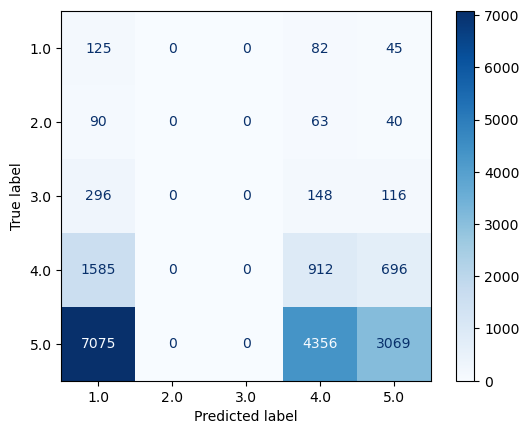

In [40]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred, labels=baseline_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=baseline_model.classes_)
disp.plot(cmap='Blues')

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=baseline_model.classes_, zero_division=0))

## Step 5: Final Model

In [ ]:
column_transformer = make_column_transformer(
    (PolynomialFeatures(), ['calories', 'protein (PDV)']),
    (FunctionTransformer(), ['calories']),
    (StandardScaler(), ['minutes']),
    (OneHotEncoder(drop='first'), ['meal']),
    remainder='drop'
)

pipeline = make_pipeline(
    column_transformer,
    OneVsRestClassifier(LogisticRegression(class_weight='balanced', random_state=23))
)

param_grid = {
    'columntransformer__polynomialfeatures__degree': [2, 3, 4],
    'columntransformer__functiontransformer__func': [np.log1p, np.sqrt],
    'onevsrestclassifier__estimator__C': [0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
)
grid.fit(X_train, y_train)

y_pred_final = grid.best_estimator_.predict(X_test)

/Users/in/miniforge3/envs/pds/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/in/miniforge3/envs/pds/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/in/

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('polynomialfeatures',
                                                                         PolynomialFeatures(),
                                                                         ['calories',
                                                                          'protein '
                                                                          '(PDV)']),
                                                                        ('functiontransformer',
                                                                         FunctionTransformer(),
                                                                         ['calories']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['minutes']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['meal'])])),
                                       ('onevsrestclassifier',
                                        OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                                         random_state=23)))]),
             param_grid={'columntransformer__functiontransformer__func': [<ufunc 'log1p'>,
                                                                          <ufunc 'sqrt'>],
                         'columntransformer__polynomialfeatures__degree': [2, 3,
                                                                           4],
                         'onevsrestclassifier__estimator__C': [0.01, 0.1, 1, 10,
                                                               100]},
             scoring='accuracy')

Best Parameters: {'columntransformer__functiontransformer__func': <ufunc 'sqrt'>, 'columntransformer__polynomialfeatures__degree': 2, 'onevsrestclassifier__estimator__C': 0.1}
Best Cross-Validation Score: 0.24429489959872006
Accuracy: 0.28644774842229115
Classification Report:
              precision    recall  f1-score   support

         1.0       0.02      0.26      0.03       252
         2.0       0.01      0.21      0.03       193
         3.0       0.04      0.04      0.04       560
         4.0       0.19      0.37      0.26      3193
         5.0       0.79      0.28      0.41     14500

    accuracy                           0.29     18698
   macro avg       0.21      0.23      0.15     18698
weighted avg       0.65      0.29      0.36     18698



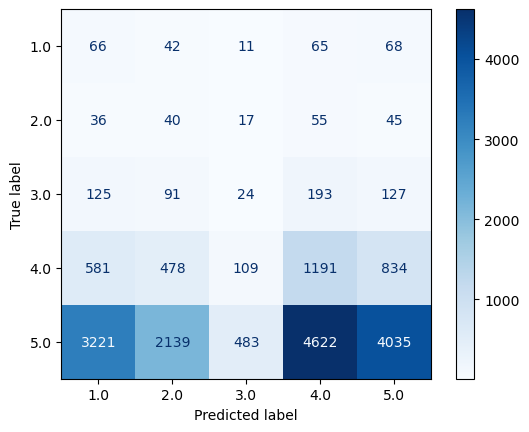

In [ ]:
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)

accuracy_final = accuracy_score(y_test, y_pred_final)
print(f"Accuracy: {accuracy_final}")

print("Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=grid.classes_, zero_division=0))

conf_matrix_final = confusion_matrix(y_test, y_pred_final, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_final, display_labels=grid.classes_)
disp.plot(cmap='Blues')